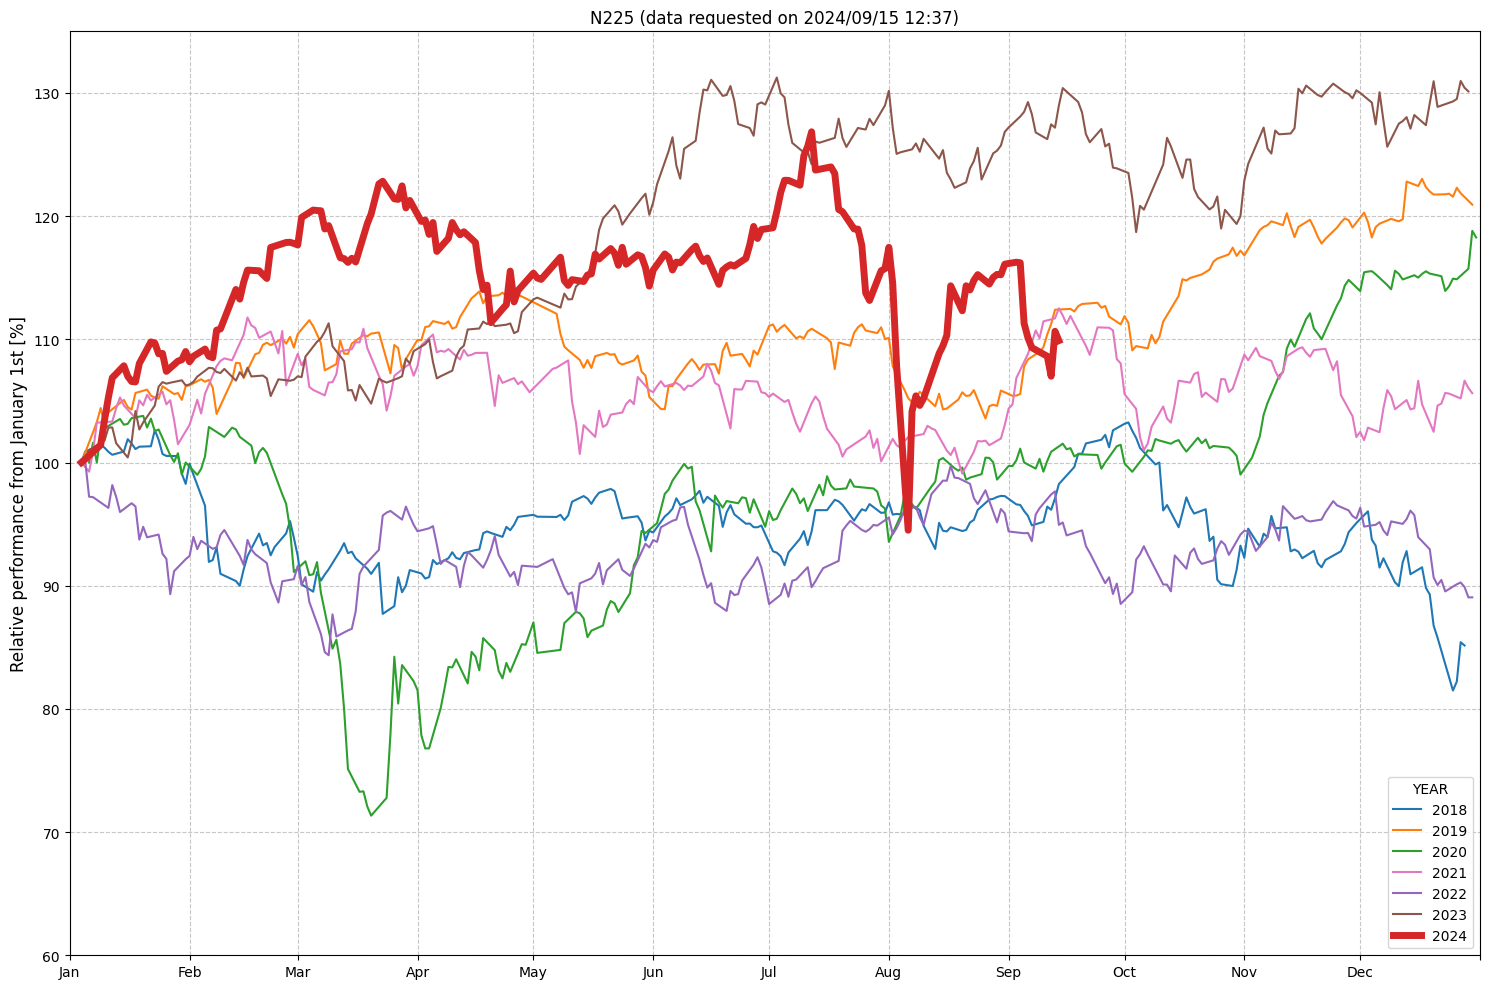

In [8]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 日経平均のデータを取得（ティッカーシンボルは^N225を使用）
topix = yf.Ticker("^N225")
start_date = "2018-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
data = topix.history(start=start_date, end=end_date)

# 各年の最初の取引日の終値を100%として正規化
yearly_data = {}
for year in range(2018, datetime.now().year + 1):
    year_data = data[data.index.year == year]['Close']
    if not year_data.empty:
        base_value = year_data.iloc[0]
        yearly_data[year] = (year_data / base_value) * 100

# プロットの作成
str_now = datetime.now().strftime("%Y/%m/%d %H:%M")
plt.figure(figsize=(15, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#e377c2', '#9467bd', '#8c564b', '#d62728']

for i, (year, values) in enumerate(yearly_data.items()):
    if year == datetime.now().year:
        plt.plot(values.index.dayofyear, values, label=str(year), color=colors[-1], linewidth=5)
    else:
        plt.plot(values.index.dayofyear, values, label=str(year), color=colors[i % len(colors)])

plt.legend(title='YEAR', fontsize=10, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(1, 366)
plt.ylim(60, 135)

plt.xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366],
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])

plt.ylabel('Relative performance from January 1st [%]', fontsize=12)
plt.title('N225 (data requested on ' + str_now + ')', fontsize=12)
plt.tight_layout()
plt.show()